# SCADAA Report

In [5]:
import numpy as np
from numpy.linalg import inv
from scipy.integrate import odeint, solve_ivp
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from exercise2 import DGM_Layer, Net_DGM
from exercise2 import FFN


## Exercise 1.1

In [6]:
class LQR:
    def __init__(self, H, M, sigma, alpha, alpha_s, C, D, R, T) -> None:
        self.H = H 
        self.M = M
        self.sigma = sigma
        self.alpha = alpha 
        self.alpha_s = alpha_s
        self.C = C 
        self.D = D 
        self.R = R
        self.T = T
    

    def riccati_ode(self, t, S_flat):
        S = torch.tensor(S_flat, dtype=torch.float32).reshape((2, 2))  # Convert S_flat to a PyTorch tensor
        dS = (-2 * (self.H.t() @ S) + S @ (self.M) @ (torch.inverse(self.D)) @ (np.transpose(self.M)) @ S - self.C)
        return dS.flatten().detach().numpy()
 

    def solve_ricatti_ode(self, time_grid):
        """
        Solves the LQR problem by integrating the 
        Riccati equation backwards in time.
        """
        # Time points (reversed for backward integration)
        # t_points = np.linspace(0, self.T, 1000)[::-1]  
        intial_cond = self.R.flatten().detach().numpy()

        sol = solve_ivp(
            self.riccati_ode, [self.T.item(), time_grid[0].item()], 
            intial_cond, t_eval=time_grid.numpy()[::-1], method='RK45'
            )
        
        S = torch.tensor(sol.y)

        return S

    def visualize_results(self, t_points, S):
        """
        Visualizes the solution of the Riccati equation 
        or the state/control trajectories.
        """
        # S_00 = [s[0, 0].item() for s in S]
        plt.plot(t_points, S[0, :])
        plt.xlabel('Time')
        plt.ylabel('S[0,0]')
        plt.title('Solution of Riccati Equation over Time')
        plt.show()
        

    def markov_control(self, t_batch, x_batch):
        S = self.solve_ricatti_ode(t_batch).reshape(-1, 2, 2).float()
        x_batch = x_batch.view(x_batch.size(0), 2)
        
        a = - ((torch.inverse(self.D.float()) @ self.M.T) @ S) @ x_batch.unsqueeze(-1)

        return a.squeeze(-1)


    def value_function(self, t_batch, x_batch):
        S = self.solve_ricatti_ode(t_batch).reshape(-1, 2, 2).float()
        x_batch = x_batch.view(x_batch.size(0), 2, 1)

        # Compute the first term: x.transpose(S)x
        x_S_x = torch.matmul(torch.matmul(x_batch.transpose(1, 2), S), x_batch).squeeze()

        # Compute the integral term
        integral_term = 0
        for t, s in zip(t_batch, S):
            # Compute the trace term
            trace = (self.sigma @ self.sigma.T) @ s
            trace_term = torch.trace(trace.view(trace.size(0), -1))

            integral_term += trace_term * (self.T - t) / len(t_batch)

        # Compute the total value function: v(t, x) = x.transpose(S)x + trace_term
        v = x_S_x + integral_term

        return v


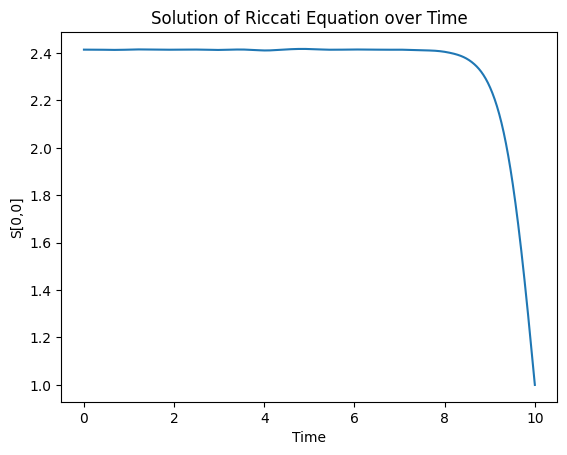

Optimal Markov Control:
tensor([[-7.2402, -2.4134],
        [ 0.0000,  0.0000],
        [ 4.8280, -2.4125]])
Value Function:
tensor([26.9513, 14.8844, -4.4247])


In [7]:
# Example Usage:
# Define problem matrices
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
C = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
R = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
alpha = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
alpha_s = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(10.0, dtype=torch.float32)

# Initialize LQRController
# controller = LQRController(H, M, D, C, R, T)

# Define time grid
time_grid = torch.linspace(0, T, 1000)

lqr_system = LQR(H, M, sigma, alpha, alpha_s, C, D, R, T)
S_solution = lqr_system.solve_ricatti_ode(time_grid)
lqr_system.visualize_results(torch.flip(time_grid, [0]), S_solution)

# Create sample input tensors
t_batch = torch.tensor([0.5, 0.8, 1.0], dtype=torch.float32)  # Sample time values
x_batch = torch.tensor([
    [[1.0, 2.0]],  
    [[-1.0, 0.0]], 
    [[3.0, -2.0]]  
], dtype=torch.float32)  # Sample spatial values

# Compute the markov control
markov_control = lqr_system.markov_control(t_batch, x_batch)

# Print the computed value function
print("Optimal Markov Control:")
print(markov_control)

# Compute the value function
value_func = lqr_system.value_function(t_batch, x_batch)

# Print the computed value function
print("Value Function:")
print(value_func)



## Exercise 1.2

1. Error

2. Time

In [21]:
# Function to generate training data
def generate_xs(num_samples):
    x = torch.tensor(np.random.uniform(-3, 3, (num_samples, 2)), dtype=torch.float32)
    return x

#Create error function
def calculate_error(X):
    #We might want to have a better error function tbh
    error = np.linalg.norm(X - np.zeros(X.shape))
    return error



In [9]:
#Initial Conditions
H = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
M = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
sigma = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
D = torch.tensor([[1, 0], [0, 1]], dtype=torch.float32)
T = torch.tensor(10.0, dtype=torch.float32)
x0 = np.array([0.0, 0.0])

In [44]:
#Initialize step sizes and sample size
N_steps = [1, 10, 50, 100, 500, 1000, 5000]
N_samples = 10
#Initialize terminal X list and error list
error = []

def generate_x_samples(num_samples, time_grid):
    return np.array([generate_xs(time_grid.size(dim=0)) for n in range(num_samples)])

def calculate_mean_error(time_grid, x_samples):
    # t_values = torch.linspace(t0, T, len(x_samples))
    values = [lqr_system.value_function(time_grid, x) for x in x_samples]
    return np.mean([calculate_error(values) for n in range(len(values))])

time_grid = torch.linspace(0, 10, 10)
x = generate_x_samples(10, time_grid)
# print(x)
print(calculate_mean_error(time_grid, x))

#Calculate the terminal X's and the error
for steps in N_steps:
    x_values = generate_xs(steps)
    t_values = torch.linspace(0, 10, steps)
    value_func = lqr_system.value_function(t_values, x_values)
    
    current_error = calculate_error(x_values)
    error.append(current_error)

# print(error)


TypeError: 'int' object is not callable

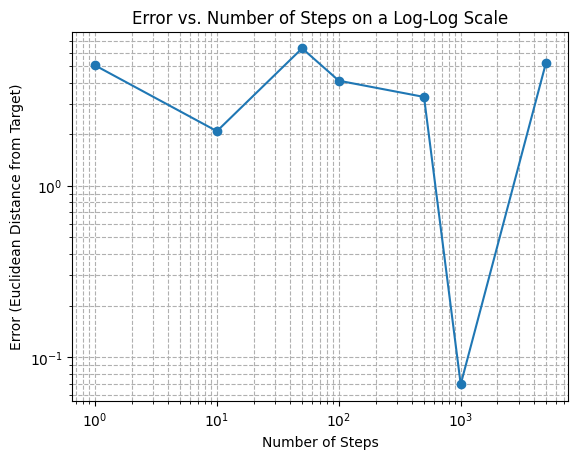

In [17]:
#Plot the error
plt.loglog(N_steps, error, marker='o', linestyle='-')
plt.xlabel('Number of Steps')
plt.ylabel('Error (Euclidean Distance from Target)')
plt.title('Error vs. Number of Steps on a Log-Log Scale')
plt.grid(True, which="both", ls="--")
plt.show()


Exercise 2

In [12]:
# Function to generate training data
def generate_training_data(T, num_samples):
    # t = torch.tensor(np.random.uniform(0, T, num_samples), dtype=torch.float32)
    t = torch.linspace(0, T, num_samples)
    x = torch.tensor(np.random.uniform(-3, 3, (num_samples, 2)), dtype=torch.float32)
    return t, x

tensor([14.8586, 43.3352, 30.3800, 10.6295, 10.6295, 10.6295, 10.6295, 15.5500,
        23.7529, 11.0838])
Epoch 0, Loss: 448.0921936035156
Epoch 100, Loss: 110.90495300292969
Epoch 200, Loss: 110.9018783569336
Epoch 300, Loss: 110.90174865722656
Epoch 400, Loss: 110.90171813964844
Epoch 500, Loss: 110.90167236328125
Epoch 600, Loss: 110.90164947509766
Epoch 700, Loss: 110.90161895751953
Epoch 800, Loss: 110.90161895751953
Epoch 900, Loss: 110.90160369873047


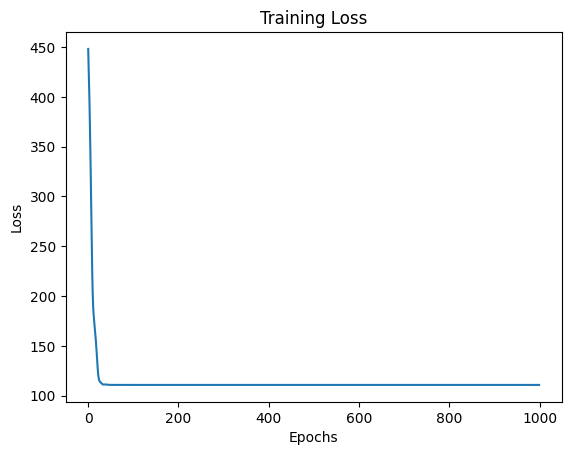

In [15]:
# Function to train the neural network
def train_net_dgm(net_dgm, t_train, x_train, epochs=1000, lr=0.001):
    optimizer = optim.Adam(net_dgm.parameters(), lr=lr)
    criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        v_pred = net_dgm(t_train.unsqueeze(1), x_train)  # Predict value function
        loss = criterion(v_pred, lqr_system.value_function(t_train, x_train))  # Compute loss
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 10
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
print(lqr_system.value_function(t_train, x_train))

# Initialize the neural network
net_dgm = Net_DGM(dim_x=2, dim_S=100, hidden_size=100)

# Train the neural network
losses = train_net_dgm(net_dgm, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()


tensor([[ 3.0664,  6.9593],
        [-2.1471, -2.1468],
        [-6.9956,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000,  0.0000],
        [ 0.0000, -1.6034],
        [10.0715, 10.0826],
        [ 2.7343,  2.7341]])
Epoch 0, Loss: 17.98061752319336
Epoch 100, Loss: 0.8265073895454407
Epoch 200, Loss: 0.12694218754768372
Epoch 300, Loss: 0.01999618299305439
Epoch 400, Loss: 0.0023203629534691572
Epoch 500, Loss: 0.00014991514035500586
Epoch 600, Loss: 5.215920737100532e-06
Epoch 700, Loss: 1.0270392891698066e-07
Epoch 800, Loss: 1.1410266065325914e-09
Epoch 900, Loss: 1.24283638935907e-11


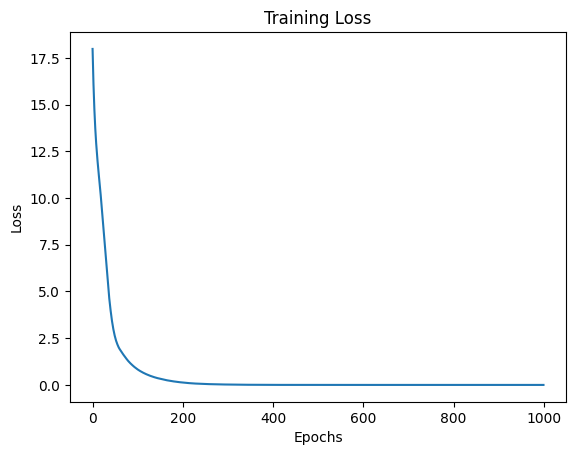

In [14]:
# Function to train the neural network
def train_ffn_net(net_ffn, t_train, x_train, epochs=1000, lr=0.001):
    optimizer = optim.Adam(net_ffn.parameters(), lr=lr)
    # criterion = nn.MSELoss()

    losses = []

    for epoch in range(epochs):
        optimizer.zero_grad()
        a_pred = net_ffn(torch.cat((t_train.unsqueeze(1), x_train), dim=1))  # Predict markov control
        loss = loss = nn.MSELoss()(a_pred, lqr_system.markov_control(t_train, x_train))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if epoch % 100 == 0:
            print(f'Epoch {epoch}, Loss: {loss.item()}')

    return losses

# Generate training data
T = 10
num_samples = 10
t_train, x_train = generate_training_data(T, num_samples)
print(lqr_system.markov_control(t_train, x_train))

# Define the sizes for the FFN network
sizes = [3, 100, 100, 2]  # Input size is 3 (time + 2 coordinates), 2 hidden layers of size 100, output size is 2

# Initialize the neural network
net_ffn = FFN(sizes)

# Train the neural network
losses = train_ffn_net(net_ffn, t_train, x_train)

# Plot the training loss
plt.plot(losses)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()
